In [1]:
# Importing all the required libraries.
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2
from typing import List, Tuple
import json
from numpy import linalg as LA
import imutils
import warnings
import os
import glob

In [2]:

def readImage(path):
    img =Image.open(path).convert('L')
    img.resize((1600,1200))
    return img

def getHomography(img1, img2):
    try:
        orig_image = np.array(img1)
        skewed_image = np.array(img2)
        print(f"Image 1 shape: {orig_image.shape}")
        print(f"Image 2 shape: {skewed_image.shape}")
        if len(orig_image.shape) == 3:
            orig_image = cv2.cvtColor(orig_image, cv2.COLOR_RGB2GRAY)
        if len(skewed_image.shape) == 3:
            skewed_image = cv2.cvtColor(skewed_image, cv2.COLOR_RGB2GRAY)
        detector = None
        detector_name = ""
        try:
            detector = cv2.xfeatures2d.SURF_create(500)
            detector_name = "SURF"
            print("Using SURF detector")
        except (AttributeError, cv2.error):
            print("SURF not available, trying SIFT...")

        if detector is None:
            try:
                detector = cv2.SIFT_create(nfeatures=1000)
                detector_name = "SIFT"
                print("Using SIFT detector")
            except (AttributeError, cv2.error):
                print("SIFT not available, trying ORB...")
        if detector is None:
            try:
                detector = cv2.ORB_create(nfeatures=1000)
                detector_name = "ORB"
                print("Using ORB detector")
            except (AttributeError, cv2.error):
                print("ORB not available")

        if detector is None:
            print("No feature detector available!")
            return None
        print("Detecting keypoints and computing descriptors...")
        kp1, des1 = detector.detectAndCompute(orig_image, None)
        kp2, des2 = detector.detectAndCompute(skewed_image, None)
        print(f"Keypoints in image 1: {len(kp1) if kp1 else 0}")
        print(f"Keypoints in image 2: {len(kp2) if kp2 else 0}")
        if des1 is None or des2 is None or len(kp1) < 4 or len(kp2) < 4:
            print("Not enough keypoints found for homography estimation")
            return None
        print(f"Descriptors shape - Image 1: {des1.shape}, Image 2: {des2.shape}")
        good_matches = []
        if detector_name == "ORB":
            print("Using BFMatcher for ORB...")
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = bf.match(des1, des2)
            matches = sorted(matches, key=lambda x: x.distance)
            # Take top matches
            good_matches = matches[:min(len(matches), 100)]
            print(f"ORB matches found: {len(good_matches)}")
        else:
            print("Using FLANN matcher for SURF/SIFT...")
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
            flann = cv2.FlannBasedMatcher(index_params, search_params)
            des1 = des1.astype(np.float32)
            des2 = des2.astype(np.float32)
            matches = flann.knnMatch(des1, des2, k=2)
            for match_pair in matches:
                if len(match_pair) == 2:
                    m, n = match_pair
                    if m.distance < 0.7 * n.distance:
                        good_matches.append(m)
            print(f"FLANN good matches found: {len(good_matches)}")
        MIN_MATCH_COUNT = 10
        if len(good_matches) < MIN_MATCH_COUNT:
            print(f"Not enough matches found: {len(good_matches)}/{MIN_MATCH_COUNT}")
            return None

        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        print("Computing homography...")
        H, mask = cv2.findHomography(src_pts, dst_pts,
                                   method=cv2.RANSAC,
                                   ransacReprojThreshold=5.0,
                                   confidence=0.99)

        if H is not None:
            print("Homography matrix found successfully")
            print(f"Homography shape: {H.shape}")
            # Check if homography is reasonable (not too distorted)
            if np.linalg.det(H) > 0.1:  # Avoid overly distorted transformations
                return H
            else:
                print("Homography appears to be degenerate")
                return None
        else:
            print("findHomography returned None")
            return None

    except Exception as e:
        print(f"Error in getHomography: {str(e)}")
        print(f"Error type: {type(e)}")
        return None


def makePoints():
    # Manually setting up the points for the given template image
    a= [
[511,126],[562,150],[533,182],[510,203],[559,230],[559,252],[533,280],[585,304],[535,331],[534,355],[535,382],[534,409],[534,433],[509,459],[510,485],[535,514],[586,540],[506,565],[509,586],[586,612],[509,640],[560,666],[558,691],[510,722],[560,746],[534,773],[510,798],[561,822],[508,846],[585,874],[586,901],[536,926],[535,953],[559,981],[510,1005],[662,127],[687,153],[710,181],[737,206],[686,230],[710,254],[737,282],[686,310],[712,333],[662,360],[737,387],[737,410],[687,438],[713,458],[736,486],[711,514],[688,540],[711,564],[688,588],[662,614],[661,643],[714,668],[686,695],[710,723],[712,746],[711,773],[710,799],[738,823],[661,848],[661,878],[687,899],[687,929],[689,954],[687,980],[689,1006],[842,127],[842,154],[842,181],[842,205],[867,232],[844,256],[867,283],[841,307],[866,332],[816,357],[891,386],[870,410],[842,437],[867,462],[892,490],[842,514],[867,541],[866,565],[842,592],[866,614],[841,643],[867,665],[841,693],[817,723],[868,747],[893,774],[817,797],[893,825],[842,848],[890,880],[868,901],[843,929],[868,952],[866,980],[816,1004],[1022,126],[998,150],[1022,178],[998,205],[1022,229],[997,256],[1021,283],[1000,310],[1022,335],[1022,358],[1023,386],[1022,413],[1023,436],[1023,461],[998,491],[1023,514],[997,541],[1022,564],[1021,589],[995,616],[1024,644],[1021,668],[999,696],[972,725],[998,745],[1022,775],[997,801],[973,824],[1021,850],[1020,875],[1047,902],[997,928],[997,954],[971,979],[969,1004],[509,1048],[534,1072],[562,1098],[559,1122],[534,1151],[508,1176],[534,1201],[534,1225],[509,1254],[508,1276],[533,1309],[510,1332],[558,1359],[558,1385],[508,1406],[664,1047],[666,1073],[664,1100],[690,1123],[688,1146],[738,1175],[662,1200],[687,1226],[686,1255],[690,1280],[713,1304],[739,1331],[687,1359],[689,1386],[690,1411],[842,1049],[842,1074],[868,1102],[843,1123],[842,1151],[843,1178],[868,1202],[818,1229],[843,1254],[818,1280],[868,1306],[842,1330],[868,1355],[843,1382],[818,1404],[998,1048],[1022,1074],[1020,1098],[1046,1124],[1047,1147],[1022,1174],[1021,1202],[996,1227],[1022,1253],[997,1278],[995,1305],[970,1332],[974,1358],[971,1383],[971,1407],[534,126],[561,126],[585,125],[510,151],[535,150],[586,148],[508,177],[559,178],[584,178],[534,203],[558,203],[583,202],[586,229],[535,229],[510,229],[509,253],[534,254],[586,254],[510,282],[558,283],[586,281],[510,306],[534,308],[559,310],[509,332],[558,333],[587,335],[511,357],[559,356],[586,358],[510,385],[559,386],[584,385],[510,410],[558,410],[586,412],[510,435],[559,436],[585,434],[535,460],[558,460],[585,458],[534,488],[560,488],[584,488],[510,512],[560,512],[585,514],[510,539],[535,538],[561,538],[534,564],[561,563],[586,565],[535,588],[561,589],[584,589],[510,612],[533,614],[561,616],[534,643],[562,645],[584,641],[511,668],[535,666],[586,669],[510,692],[532,692],[585,693],[535,721],[558,723],[586,720],[508,746],[535,746],[584,748],[510,772],[560,772],[586,772],[536,798],[560,798],[584,797],[511,821],[536,822],[586,822],[537,849],[561,849],[587,847],[510,878],[534,880],[560,873],[512,902],[535,899],[561,901],[509,927],[560,928],[584,927],[509,951],[560,951],[585,952],[510,978],[585,978],[534,979],[534,1003],[558,1005],[585,1004],[663,1003],[713,1003],[736,1005],[737,982],[714,982],[662,980],[665,953],[714,956],[740,953],[737,926],[714,928],[663,928],[662,903],[715,904],[738,902],[690,878],[712,877],[738,877],[738,850],[688,850],[713,848],[712,822],[686,823],[664,823],[665,800],[689,798],[740,797],[738,773],[685,770],[659,775],[660,749],[688,747],[738,748],[739,726],[690,725],[661,722],[662,694],[712,698],[738,696],[736,670],[687,669],[661,667],[688,646],[713,644],[739,646],[738,618],[711,616],[685,614],[662,590],[713,590],[737,590],[662,564],[686,566],[736,564],[736,540],[661,538],[712,537],[737,509],[688,513],[662,513],[661,491],[689,490],[711,491],[738,461],[686,463],[660,460],[661,436],[710,437],[738,437],[710,409],[686,410],[660,409],[662,385],[685,385],[711,388],[737,355],[708,354],[685,357],[662,333],[690,335],[736,333],[711,306],[734,308],[662,310],[688,130],[714,131],[739,130],[662,153],[713,152],[737,152],[738,182],[686,182],[661,182],[662,204],[687,203],[713,206],[662,229],[710,228],[738,230],[661,254],[689,255],[735,255],[662,282],[688,283],[711,283],[817,124],[817,154],[816,179],[816,208],[815,230],[818,258],[815,284],[814,307],[818,338],[842,234],[840,286],[842,337],[840,361],[814,387],[815,414],[815,438],[815,465],[813,493],[816,515],[817,544],[815,566],[815,590],[816,618],[817,646],[815,668],[817,696],[867,130],[866,149],[866,184],[866,207],[866,261],[890,129],[890,155],[893,181],[890,206],[891,231],[891,256],[891,283],[892,309],[867,310],[894,335],[892,359],[865,356],[869,389],[845,390],[841,413],[894,411],[869,437],[892,437],[890,464],[842,462],[841,489],[866,490],[866,515],[892,514],[840,542],[892,541],[893,564],[893,591],[844,565],[868,594],[844,618],[892,616],[865,642],[891,641],[891,666],[893,693],[841,670],[868,695],[894,722],[866,722],[841,723],[840,747],[819,745],[813,773],[841,772],[864,774],[890,798],[867,799],[844,798],[815,822],[836,822],[862,823],[818,849],[866,848],[891,848],[869,877],[841,874],[818,872],[815,899],[839,901],[890,899],[893,926],[863,927],[817,927],[816,952],[840,952],[891,950],[889,980],[838,981],[818,981],[839,1006],[866,1002],[890,1003],[973,128],[997,127],[1049,129],[1049,153],[1022,153],[974,150],[971,181],[996,180],[1047,181],[1047,205],[1023,204],[974,202],[970,230],[997,228],[1050,232],[970,256],[1025,257],[1048,252],[1050,282],[1047,308],[998,281],[974,284],[973,307],[1020,309],[1047,334],[998,335],[974,335],[974,358],[995,358],[1050,357],[1046,385],[996,386],[972,385],[973,412],[996,409],[1048,415],[1045,433],[996,435],[971,437],[974,459],[996,459],[1047,460],[1047,489],[974,490],[1022,490],[1047,514],[999,514],[973,514],[970,539],[1023,540],[1050,541],[974,566],[1000,565],[1048,565],[1047,589],[999,589],[973,589],[974,614],[1020,612],[1048,612],[1046,642],[997,642],[974,641],[970,667],[998,666],[1046,666],[1046,691],[1022,695],[971,691],[998,720],[1022,722],[1047,722],[973,746],[1022,746],[1050,745],[1048,773],[998,774],[975,770],[971,796],[1018,796],[1050,796],[1049,820],[1021,822],[996,820],[975,846],[998,845],[1044,844],[1048,876],[999,873],[971,874],[973,900],[999,903],[1023,900],[1022,928],[1051,928],[971,928],[975,954],[1025,951],[1047,953],[998,982],[1022,981],[1049,981],[998,1005],[1024,1007],[1050,1007],[536,1050],[562,1046],[584,1046],[510,1073],[558,1075],[586,1074],[510,1098],[534,1098],[586,1098],[586,1123],[533,1125],[506,1122],[511,1150],[558,1150],[585,1149],[586,1176],[559,1174],[535,1175],[510,1202],[559,1200],[586,1202],[585,1226],[562,1226],[509,1226],[534,1252],[558,1251],[584,1253],[534,1279],[558,1278],[586,1280],[512,1305],[560,1302],[584,1306],[535,1329],[560,1334],[586,1331],[510,1358],[532,1357],[586,1357],[510,1387],[534,1386],[585,1388],[534,1411],[562,1410],[587,1410],[686,1049],[713,1048],[740,1049],[689,1074],[715,1074],[739,1075],[687,1098],[715,1100],[741,1101],[662,1125],[714,1124],[742,1124],[664,1151],[709,1150],[742,1147],[665,1176],[690,1177],[714,1176],[689,1204],[714,1202],[741,1204],[665,1230],[714,1230],[740,1229],[663,1254],[714,1254],[738,1253],[659,1281],[710,1282],[738,1281],[739,1307],[691,1307],[663,1306],[664,1332],[695,1330],[714,1335],[737,1358],[712,1361],[664,1358],[664,1386],[714,1385],[740,1386],[738,1410],[713,1411],[664,1410],[820,1047],[817,1073],[819,1098],[818,1125],[817,1150],[818,1178],[820,1204],[818,1254],[817,1302],[816,1333],[818,1362],[818,1386],[842,1098],[843,1204],[844,1227],[842,1282],[843,1310],[843,1358],[843,1410],[870,1048],[868,1074],[868,1123],[867,1151],[869,1176],[865,1230],[869,1254],[869,1282],[867,1332],[867,1385],[867,1409],[894,1044],[894,1074],[894,1100],[892,1125],[893,1149],[893,1173],[894,1205],[894,1229],[893,1255],[893,1282],[894,1306],[895,1330],[894,1358],[894,1386],[894,1408],[974,1046],[1022,1045],[1048,1046],[973,1071],[998,1072],[1050,1076],[974,1099],[997,1102],[1049,1102],[974,1125],[997,1125],[1024,1124],[970,1149],[996,1150],[1023,1149],[973,1175],[997,1175],[1048,1175],[1046,1201],[975,1202],[997,1201],[970,1228],[1019,1227],[1047,1229],[1048,1250],[998,1256],[972,1256],[974,1282],[1022,1280],[1048,1279],[1050,1306],[971,1306],[1022,1305],[999,1334],[1022,1334],[1046,1333],[998,1361],[1025,1355],[1050,1358],[1001,1383],[1024,1384],[1050,1385],[998,1408],[1022,1408],[1050,1408],[892,747]
]


    d=[4]*50+[4]*50+[4]*50+[4]*50
    return a,d


def getsCorrspondingPoints(points, H):
    if H is None:
        print("Error: Homography matrix is None")
        return np.array(points)

    points = np.array(points)
    x = points.shape[0]

    point = np.hstack((points, np.ones((x, 1))))
    point = point.T

    correspondingPoints = np.matmul(H, point)
    correspondingPoints = correspondingPoints.T

    for i in range(0, x):
        correspondingPoints[i][0] = correspondingPoints[i][0] / correspondingPoints[i][2]
        correspondingPoints[i][1] = correspondingPoints[i][1] / correspondingPoints[i][2]

    return correspondingPoints[:, :2]

def checkNeighboursPixels(img, points, a):
    img = np.array(img)
    points = np.array(points)
    points = points.astype('int')

    binaryImg = (img < 125).astype(np.uint8)
    kernel = np.ones((7,7), np.uint8)
    binaryImg = cv2.morphologyEx(binaryImg, cv2.MORPH_OPEN, kernel)

    plt.figure(figsize=(8,8))
    plt.imshow(binaryImg, cmap='gray')
    if(a==1):
        plt.title("Points Matching for the Ideal answer sheet")
    else:
        plt.title("Points Matching for the Students answer sheet")
    plt.scatter(points[:,0], points[:,1], s=10)
    plt.show()

    x = points.shape[0]
    n = 5
    answers = np.zeros(x)

    for i in range(0, x):
        ans = 0
        for j in range(points[i,0]-n, points[i,0]+n):
            for k in range(points[i,1]-n, points[i,1]+n):
                if(binaryImg[k][j]):
                    ans += 1
        answers[i] = ans

    min_filled_pixels = 35
    answers = answers > min_filled_pixels

    return answers.astype('int')

def getAnswers(img1, img2, points, a):
    print(f"Processing images for answer detection...")

    homography = getHomography(img1, img2)

    if homography is None:
        print("Warning: Could not find homography between images")
        print("Using original points (assuming images are already aligned)")
        correspondingPoints = np.array(points)
    else:
        print("Homography found successfully")
        correspondingPoints = getsCorrspondingPoints(points, homography)
    answer = checkNeighboursPixels(img2, correspondingPoints, a)
    return answer

def cal_score(o,t,img,pts):
    wrong = []
    correct = []
    score=0
    for i in range(np.array(pts).shape[0]):
        if t[i] ==1:
            if o[i] != t[i]:
                wrong.append(pts[i])
                score-=1
            if o[i] == t[i]:
                correct.append(pts[i])
                score+=4

    correct = np.array(correct)
    wrong = np.array(wrong)
    #print(correct)
    plt.figure(figsize=(8,8))
    plt.imshow(np.array(img),cmap='gray')
    plt.scatter(correct[:,0],correct[:,1],c = 'g',s=10)
    plt.scatter(wrong[:,0],wrong[:,1],c = 'r',s=10)
    plt.title("Right Answers by Green & Wrong answers by Red and unresponded are left blank")
    plt.show()
    print(score)

    return score

In [3]:
warnings.filterwarnings("ignore")
original_image = None
scanned_sheet = None

def load_image(image_path):
    global original_image
    try:
        original_image = cv2.imread(image_path)
        if original_image is None:
            raise ValueError(f"Could not load image from {image_path}")
        print(f"Loaded image with dimensions: {original_image.shape}")
        return True
    except Exception as e:
        print(f"Error loading image: {e}")
        return False

def detect_paper_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)
    h, w = gray.shape
    mask = np.zeros_like(gray)
    border_size = min(h, w) // 8
    mask[:border_size, :] = 255
    mask[-border_size:, :] = 255
    mask[:, :border_size] = 255
    mask[:, -border_size:] = 255
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    processed = cv2.morphologyEx(blurred, cv2.MORPH_GRADIENT, kernel)
    processed = cv2.bitwise_and(processed, mask)
    return processed

def find_paper_contour_canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    filtered = cv2.bilateralFilter(gray, 11, 17, 17)
    blurred = cv2.GaussianBlur(filtered, (21, 21), 0)
    adaptive_thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 10
    )
    canny_configs = [
        (30, 100),
        (50, 150),
        (20, 80),
        (40, 120)
    ]

    best_contour = None
    max_score = 0

    for low_thresh, high_thresh in canny_configs:
        edges = cv2.Canny(adaptive_thresh, low_thresh, high_thresh)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        edges = cv2.dilate(edges, kernel, iterations=2)
        edges = cv2.erode(edges, kernel, iterations=1)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
        contours = sorted(contours, key=lambda c: cv2.contourArea(c), reverse=True)
        for contour in contours[:3]:  # Check top 3 contours
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            if area < 10000 or perimeter < 500:
                continue
            epsilon = 0.02 * perimeter
            approx = cv2.approxPolyDP(contour, epsilon, True)
            if len(approx) == 4:
                rect = cv2.boundingRect(approx)
                rect_area = rect[2] * rect[3]
                extent = area / rect_area if rect_area > 0 else 0
                aspect_ratio = rect[2] / rect[3] if rect[3] > 0 else 0
                if 0.5 <= aspect_ratio <= 0.95 and extent > 0.7:
                    image_area = image.shape[0] * image.shape[1]
                    area_ratio = area / image_area
                    score = area_ratio * extent * (1 - abs(aspect_ratio - 0.75))
                    if score > max_score:
                        max_score = score
                        best_contour = approx
    return best_contour

def find_paper_contour_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    background = cv2.GaussianBlur(gray, (51, 51), 0)
    diff = cv2.absdiff(gray, background)
    _, thresh = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    largest_contour = max(contours, key=cv2.contourArea)
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    if len(approx) == 4:
        return approx
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    return np.int0(box).reshape(-1, 1, 2)

def find_paper_edges_combined(image):
    methods = [
        find_paper_contour_canny,
        find_paper_contour_threshold
    ]
    candidates = []

    for method in methods:
        try:
            contour = method(image)
            if contour is not None and len(contour) == 4:
                area = cv2.contourArea(contour)
                image_area = image.shape[0] * image.shape[1]
                area_ratio = area / image_area
                if 0.3 <= area_ratio <= 0.95:
                    candidates.append((contour, area_ratio))
        except:
            continue
    if not candidates:
        return None
    best_candidate = max(candidates, key=lambda x: x[1])
    return best_candidate[0]

def order_corners(corners):
    corners = corners.reshape(4, 2).astype(np.float32)
    center_x = np.mean(corners[:, 0])
    center_y = np.mean(corners[:, 1])
    def angle_from_center(point):
        return np.arctan2(point[1] - center_y, point[0] - center_x)
    sorted_corners = sorted(corners, key=angle_from_center)
    ordered = np.zeros((4, 2), dtype=np.float32)
    for corner in corners:
        if corner[0] < center_x and corner[1] < center_y:
            ordered[0] = corner  # top-left
        elif corner[0] > center_x and corner[1] < center_y:
            ordered[1] = corner  # top-right
        elif corner[0] > center_x and corner[1] > center_y:
            ordered[2] = corner  # bottom-right
        else:
            ordered[3] = corner  # bottom-left
    return ordered

def extract_paper_content(image, corners, target_width=None, target_height=None):
    ordered_corners = order_corners(corners)
    if target_width is None or target_height is None:
        top_width = np.linalg.norm(ordered_corners[0] - ordered_corners[1])
        bottom_width = np.linalg.norm(ordered_corners[3] - ordered_corners[2])
        left_height = np.linalg.norm(ordered_corners[0] - ordered_corners[3])
        right_height = np.linalg.norm(ordered_corners[1] - ordered_corners[2])
        target_width = int(max(top_width, bottom_width))
        target_height = int(max(left_height, right_height))
    dst_corners = np.array([
        [0, 0],
        [target_width, 0],
        [target_width, target_height],
        [0, target_height]
    ], dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(ordered_corners, dst_corners)
    extracted = cv2.warpPerspective(image, matrix, (target_width, target_height))
    return extracted, (target_width, target_height)

def enhance_paper_scan_color_preserving(image):
    enhanced = image.copy()
    yuv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2YUV)
    y_channel = yuv[:, :, 0]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    y_channel = clahe.apply(y_channel)
    yuv[:, :, 0] = y_channel
    enhanced = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
    enhanced = cv2.bilateralFilter(enhanced, 5, 80, 80)
    kernel_sharpen = np.array([
        [0, -0.5, 0],
        [-0.5, 3, -0.5],
        [0, -0.5, 0]
    ]) / 1
    enhanced = cv2.filter2D(enhanced, -1, kernel_sharpen)
    enhanced = auto_color_balance(enhanced)
    return enhanced

def auto_color_balance(image):
    img_float = image.astype(np.float32) / 255.0
    avg_b = np.mean(img_float[:, :, 0])
    avg_g = np.mean(img_float[:, :, 1])
    avg_r = np.mean(img_float[:, :, 2])
    gray_avg = (avg_b + avg_g + avg_r) / 3.0
    if avg_b > 0:
        scale_b = gray_avg / avg_b
    else:
        scale_b = 1.0
    if avg_g > 0:
        scale_g = gray_avg / avg_g
    else:
        scale_g = 1.0
    if avg_r > 0:
        scale_r = gray_avg / avg_r
    else:
        scale_r = 1.0

    img_float[:, :, 0] = np.clip(img_float[:, :, 0] * (1 + 0.5 * (scale_b - 1)), 0, 1)
    img_float[:, :, 1] = np.clip(img_float[:, :, 1] * (1 + 0.5 * (scale_g - 1)), 0, 1)
    img_float[:, :, 2] = np.clip(img_float[:, :, 2] * (1 + 0.5 * (scale_r - 1)), 0, 1)

    return (img_float * 255).astype(np.uint8)

def enhance_paper_scan_minimal(image):
    enhanced = cv2.bilateralFilter(image, 3, 50, 50)
    alpha = 1.1
    beta = 5
    enhanced = cv2.convertScaleAbs(enhanced, alpha=alpha, beta=beta)

    return enhanced

def enhance_paper_scan_no_change(image):
    return image.copy()

def scan_paper_edges(input_path, output_path, target_width=None, target_height=None,
                    show_detection=False, enhancement_mode='color_preserving'):
    global original_image, scanned_sheet

    print("Loading image...")
    if not load_image(input_path):
        return False

    print("Detecting physical paper edges...")
    paper_contour = find_paper_edges_combined(original_image)

    if paper_contour is None:
        print("Could not detect paper edges. Using fallback method...")
        # Fallback: detect edges using simple thresholding
        gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest = max(contours, key=cv2.contourArea)
            epsilon = 0.02 * cv2.arcLength(largest, True)
            paper_contour = cv2.approxPolyDP(largest, epsilon, True)

            if len(paper_contour) != 4:
                x, y, w, h = cv2.boundingRect(largest)
                paper_contour = np.array([
                    [[x, y]], [[x+w, y]], [[x+w, y+h]], [[x, y+h]]
                ])
        else:
            h, w = original_image.shape[:2]
            margin = 20
            paper_contour = np.array([
                [[margin, margin]],
                [[w-margin, margin]],
                [[w-margin, h-margin]],
                [[margin, h-margin]]
            ])

    if show_detection:
        detection_img = original_image.copy()
        cv2.drawContours(detection_img, [paper_contour], -1, (0, 255, 0), 3)
        corners = paper_contour.reshape(4, 2)
        for i, corner in enumerate(corners):
            cv2.circle(detection_img, tuple(corner.astype(int)), 10, (255, 0, 0), -1)
            cv2.putText(detection_img, str(i), tuple(corner.astype(int)),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        plt.figure(figsize=(15, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(detection_img, cv2.COLOR_BGR2RGB))
        plt.title('Detected Paper Edges')
        plt.axis('off')

    print("Extracting paper content...")
    extracted, dimensions = extract_paper_content(
        original_image, paper_contour, target_width, target_height
    )

    print(f"Applying enhancement mode: {enhancement_mode}")
    if enhancement_mode == 'color_preserving':
        scanned_sheet = enhance_paper_scan_color_preserving(extracted)
    elif enhancement_mode == 'minimal':
        scanned_sheet = enhance_paper_scan_minimal(extracted)
    elif enhancement_mode == 'none':
        scanned_sheet = enhance_paper_scan_no_change(extracted)
    else:
        print(f"Unknown enhancement mode: {enhancement_mode}. Using 'color_preserving'.")
        scanned_sheet = enhance_paper_scan_color_preserving(extracted)

    if show_detection:
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(scanned_sheet, cv2.COLOR_BGR2RGB))
        plt.title(f'Scanned Paper ({dimensions[0]}x{dimensions[1]})')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    print(f"Saving scanned paper to {output_path}...")
    success = cv2.imwrite(output_path, scanned_sheet)

    if success:
        print(f"Paper scanning completed! Final dimensions: {dimensions}")
        return True
    else:
        print("Error saving the scanned paper.")
        return False

def batch_scan_papers(input_folder, output_folder, target_width=None, target_height=None,
                     enhancement_mode='color_preserving'):

    os.makedirs(output_folder, exist_ok=True)
    formats = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    image_files = []
    for fmt in formats:
        image_files.extend(glob.glob(os.path.join(input_folder, fmt)))
        image_files.extend(glob.glob(os.path.join(input_folder, fmt.upper())))

    if not image_files:
        print("No image files found.")
        return

    print(f"Found {len(image_files)} papers to scan.")

    for i, input_path in enumerate(image_files):
        filename = os.path.basename(input_path)
        name, ext = os.path.splitext(filename)
        output_path = os.path.join(output_folder, f"{name}_paper_scan{ext}")

        print(f"\nScanning paper {i+1}/{len(image_files)}: {filename}")

        try:
            scan_paper_edges(input_path, output_path, target_width, target_height,
                            enhancement_mode=enhancement_mode)
        except Exception as e:
            print(f"Error scanning {filename}: {e}")
            continue


Scanning with color-preserving enhancement...
Loading image...
Loaded image with dimensions: (1600, 1200, 3)
Detecting physical paper edges...
Extracting paper content...
Applying enhancement mode: color_preserving


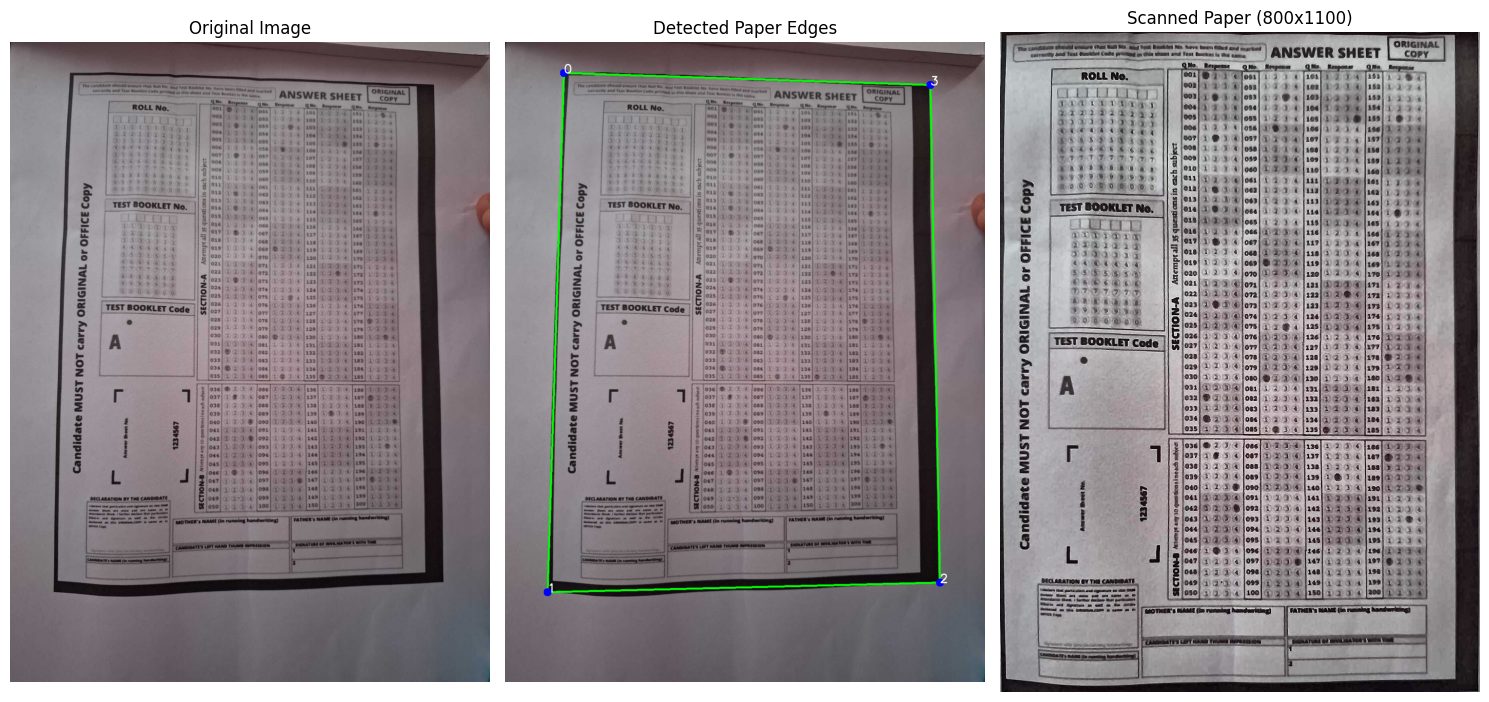

Saving scanned paper to C:/hackOdisha/omr_Dataset/scanned.png...
Paper scanning completed! Final dimensions: (800, 1100)
Processing images for answer detection...
Image 1 shape: (1650, 1141)
Image 2 shape: (1650, 1141)
SURF not available, trying SIFT...
Using SIFT detector
Detecting keypoints and computing descriptors...
Keypoints in image 1: 1000
Keypoints in image 2: 1000
Descriptors shape - Image 1: (1000, 128), Image 2: (1000, 128)
Using FLANN matcher for SURF/SIFT...
FLANN good matches found: 270
Computing homography...
Homography matrix found successfully
Homography shape: (3, 3)
Homography found successfully


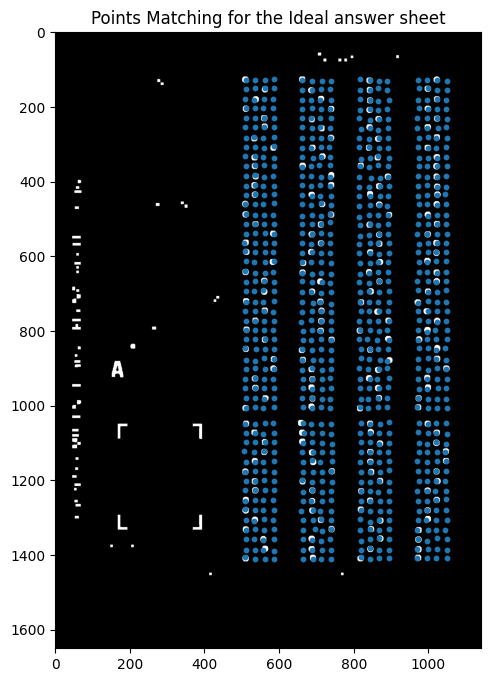

Processing images for answer detection...
Image 1 shape: (1650, 1141)
Image 2 shape: (1100, 800)
SURF not available, trying SIFT...
Using SIFT detector
Detecting keypoints and computing descriptors...
Keypoints in image 1: 1000
Keypoints in image 2: 1001
Descriptors shape - Image 1: (1000, 128), Image 2: (1001, 128)
Using FLANN matcher for SURF/SIFT...
FLANN good matches found: 100
Computing homography...
Homography matrix found successfully
Homography shape: (3, 3)
Homography found successfully


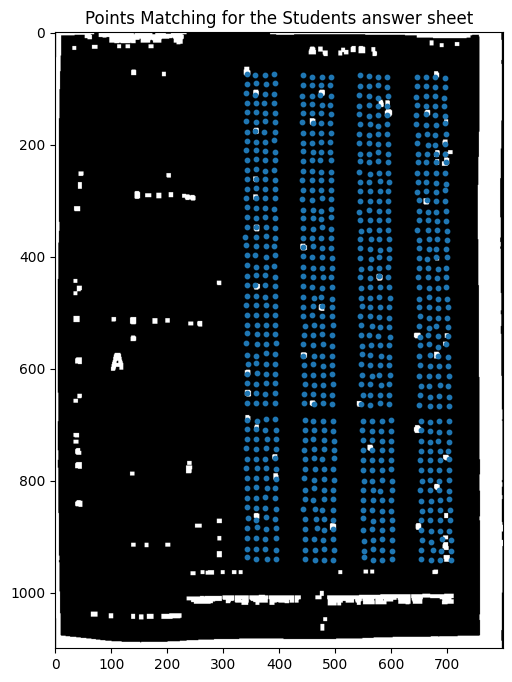

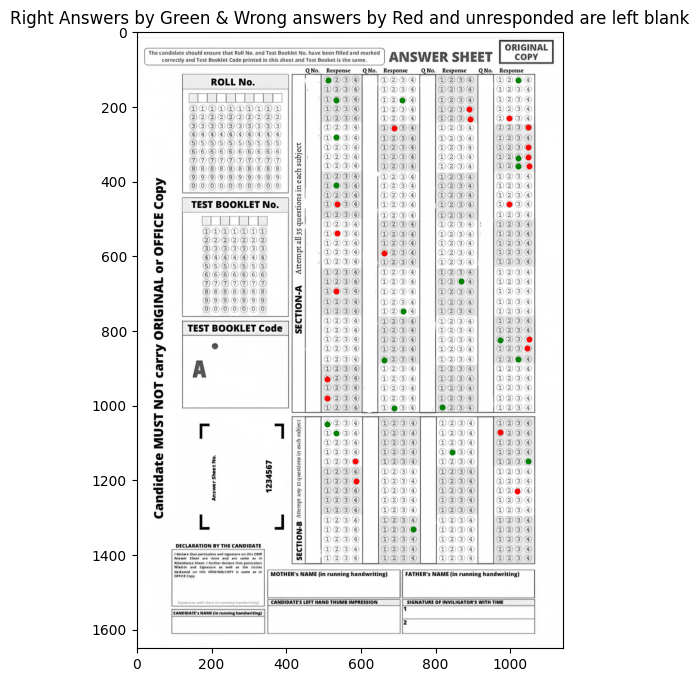

59


In [4]:
input_image = "path1.jpg"
output_image = "path2.jpg"
print("Scanning with color-preserving enhancement...")
scan_paper_edges(input_image, output_image,
                           target_width=800, target_height=1100,
                           show_detection=True,
                           enhancement_mode='color_preserving')

path1='template_image'
path2='answer_image'

templateImg=readImage(path1)
anskeyImg=readImage(path2)
testImg=readImage(output_image)

ansCordinates,distribution=makePoints()
originalAnswers=getAnswers(templateImg,anskeyImg,ansCordinates,1)
testAnswers=getAnswers(templateImg,testImg,ansCordinates,2)
marks=cal_score(originalAnswers,testAnswers,templateImg,ansCordinates,)